# CMU Machine Learning with Large Datasets

## Homework 3 - Coding 2: Machine Learning at Scale


Note that we've included code that does data loading and preparation for you. You could take a brief look to learn about how to specify a schema when loading data, or just run them all and start from "Part B Begins".

Note that we will not be autograding this notebook because of the open-ended nature of it (although you will have to submit this notebook). To make grading easier and to learn about your thought process, throughout the notebook, we include questions you have to anwswer in your writeup. Whenver this happens, there is a ✰ symbol.


### Start a Spark Session and Install Libraries


In [1]:
# You are highly recommended to select the "PySpark" kernel instead of python kernel,
# Otherwise you need to modify this cell to get pyspark working.

import pyspark
from pyspark.sql import *

sc = spark.sparkContext
print(f'num executors: {sc.getConf().get("spark.executor.instances")}')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1740238692072_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

num executors: 1

Throughout this assignment, you will be generating plots. `Matplotlib` and other useful Python libraries do not come pre-installed on the cluster. Therefore, you will have to ssh into your master node (think about why it should be the master) using your keypair created earlier and install `matplotlib`. You might have to do this later again for other libraries you use, e.g. `Pandas`.

Run the below cell to ensure you installation was successful. If an error occurs, you might want to double check your installation.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

'''
Note : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.
'''

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\nNote : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.\n'

### Data Loading and Preparation

We are hosting the converted full raw Million Song Dataset in a public S3 bucket on AWS: https://us-east-1.console.aws.amazon.com/s3/buckets/10405-spring2025-hw3-msp.

Instead of asking you to download data on your own, we provide the S3 bucket name and script below to load the converted dataset from the S3 Storage for your convenience.

Note that although you can load all chunks of the dataset using `*`, we recommend you only load in a subset while developing so that processing takes shorter time when you are just verifying your ideas.


In [3]:
from pyspark.sql.types import DoubleType, StringType, StructField, StructType

schema = StructType(
    [StructField('song_hotttnesss', DoubleType(), True),
     StructField('artist_familiarity', DoubleType(), True),
     StructField('artist_hotttnesss', DoubleType(), True),
     StructField('artist_id', StringType(), True),
     StructField('artist_latitude', DoubleType(), True),
     StructField('artist_location', StringType(), True),
     StructField('artist_longitude', DoubleType(), True),
     StructField('artist_name', StringType(), True),
     StructField('title', StringType(), True),
     StructField('danceability', DoubleType(), True),
     StructField('duration', DoubleType(), True),
     StructField('end_of_fade_in', DoubleType(), True),
     StructField('energy', DoubleType(), True),
     StructField('key', DoubleType(), True),
     StructField('key_confidence', DoubleType(), True),
     StructField('loudness', DoubleType(), True),
     StructField('mode', DoubleType(), True),
     StructField('mode_confidence', DoubleType(), True),
     StructField('start_of_fade_out', DoubleType(), True),
     StructField('tempo', DoubleType(), True),
     StructField('time_signature', DoubleType(), True),
     StructField('time_signature_confidence', DoubleType(), True),
     StructField('artist_terms', StringType(), True),
     StructField('artist_terms_freq', StringType(), True),
     StructField('artist_terms_weight', StringType(), True),
     StructField('year', DoubleType(), True)]
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#--------------------------------------------------------------------
# Set to False after writing your code and run end-to-end on full data
#--------------------------------------------------------------------
load_subset = True

#----------------------------
# DO NOT change the s3 bucket name below
#----------------------------
s3_bucket_name = '10405-spring2025-hw3-msp'

if load_subset:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/A_1.csv")
else:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/*.csv")

print('loaded {} records'.format(df.count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

loaded 10000 records

Inspect the `df` we just created by running the below cell:


In [5]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- song_hotttnesss: double (nullable = true)
 |-- artist_familiarity: double (nullable = true)
 |-- artist_hotttnesss: double (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: double (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: double (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- end_of_fade_in: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- key_confidence: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- mode_confidence: double (nullable = true)
 |-- start_of_fade_out: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- time_signature_confidence: double (nullable = true)
 |-- artist_terms: string

<div align="center">
    <h1>------------------- Part B Begins ------------------- </h1>
</div>


### 2.2.1 Exploratory Data Analysis

Now we have our data mostly ready. It's a good time to take some deeper look to better understand what we are dealing with here.

First, show summary statistics of the features using `.summary()`. Hint: because we have many features, the output might be too long for a single line. The simplest way to resolve this mess is to copy paste the output to some editor (e.g. vscode) and check the result. Another way is you could select only a few features to print at a time so that things could fit into one line.


In [6]:
# 2.2.1(a)
df.select("danceability", "duration", "energy", "tempo").summary().show(truncate=False)
# df.select("song_hotttnesss", "year").summary().show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+------------------+------+------------------+
|summary|danceability|duration          |energy|tempo             |
+-------+------------+------------------+------+------------------+
|count  |10000       |10000             |10000 |10000             |
|mean   |0.0         |247.84456666299985|0.0   |125.18470129999996|
|stddev |0.0         |119.96129193918779|0.0   |34.994327099839985|
|min    |0.0         |1.12281           |0.0   |0.0               |
|25%    |0.0         |183.11791         |0.0   |99.076            |
|50%    |0.0         |230.29506         |0.0   |122.551           |
|75%    |0.0         |286.58893         |0.0   |145.91            |
|max    |0.0         |2534.45179        |0.0   |253.357           |
+-------+------------+------------------+------+------------------+

Now looking at the statistics, `danceability` and `energy` appear strange.

✰2.2.1(a) Explain why these features seem problematic in your writeup.

Now we would like to make some histogram plots to inspect the distribution of feature values.

✰2.2.1(b) Plot histograms for `'song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'duration', 'tempo', 'year'`.

Note that one of these features may appear weird.

✰2.2.1(c) Explain what is weird about `year`'s distribution and what might cause this. Describe how you could filter `year` to make its histogram look more balanced. Hint: Choose a threshold and filter the `year` values.

✰2.2.1(d) Do it and include the new plot of this feature into your writeup.

Note: you may want to use the spark magic commands `%matplot plt` to show the plot.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

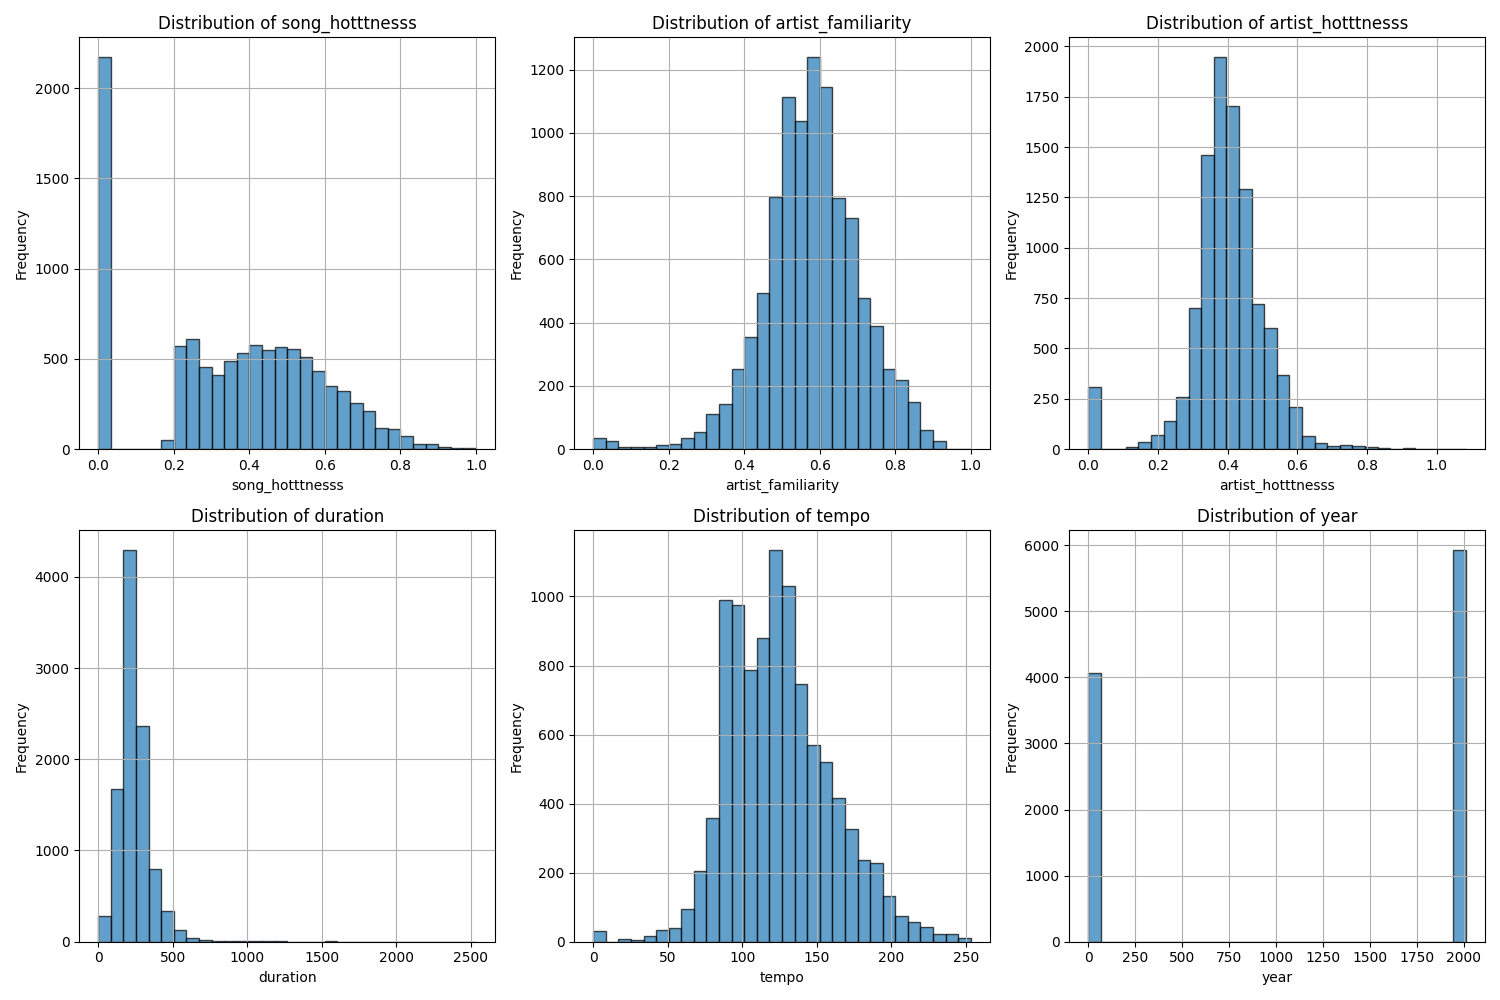

In [7]:
# 2.2.1(b)

# Define columns for plotting
features = ['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'duration', 'tempo', 'year']

df_pandas = df.select(features).toPandas()

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(features):
    df_pandas[col].hist(bins=30, ax=axes[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

%matplot plt

In [147]:
# Convert to Pandas for analysis
df_pd = df.select("year").toPandas()

# Exclude zero values to avoid missing data skewing the analysis
df_years_filtered = df[df_years["year"] > 0]

# Compute percentiles to determine a reasonable lower threshold
percentiles = df_years_filtered["year"].quantile([0.05, 0.10, 0.25])
print(percentiles)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'df_years' is not defined
Traceback (most recent call last):
NameError: name 'df_years' is not defined



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

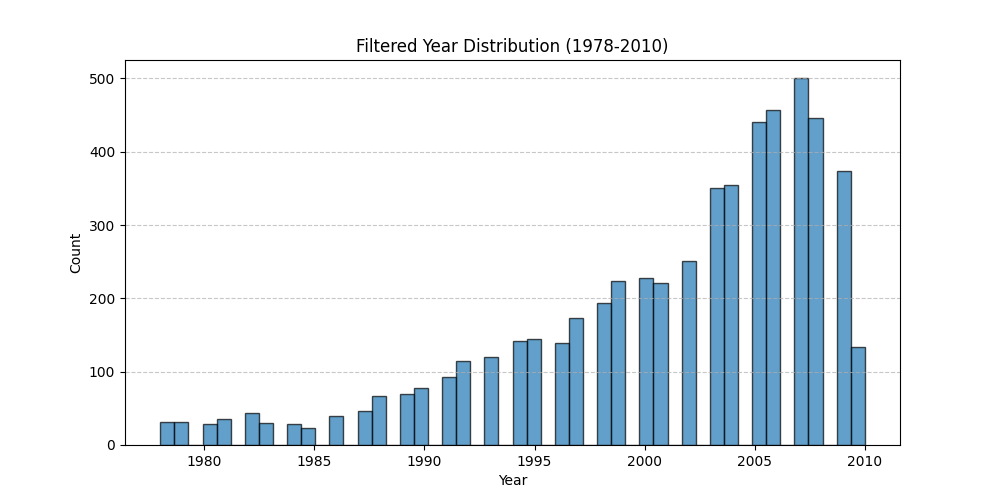

In [153]:
#2.2.1(c)

# Filter the dataset: Remove year == 0 and keep modern music (1950-2010)
df_filtered_year = df_pd[df_pd["year"] >= 1978]

# Plot the filtered distribution
plt.figure(figsize=(10, 5))
plt.hist(df_filtered_year["year"], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Filtered Year Distribution (1978-2010)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

%matplot plt

Some scatter pair plots would also be interesting to see the correlation between features.

✰2.2.1(e) Include the plots of the following pairs of features and describe your findings (e.g. what patterns you observe) in your writeup.

- `song_hotttnesss` against `artist_familiarity`
- `artist_latitude` against `artist_longitude`
- `song_hotttnesss` against `year`

Plotting all data points might explode matplotlib. Think about what simple technique you could use to visualize large datasets while retaining data distribution. ✰2.2.1(f) In your writeup, briefly describe what you did.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

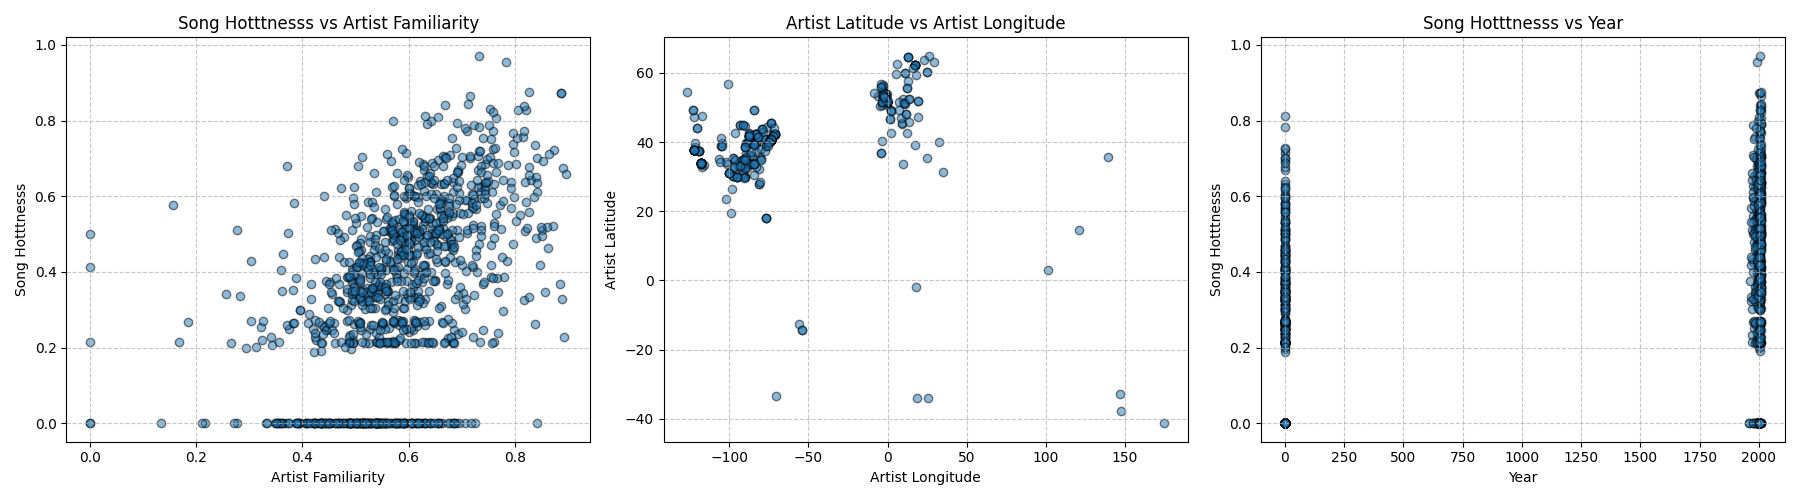

In [166]:
# 2.2.1(e)
# Convert relevant features to Pandas for visualization
df_pairs = df[["song_hotttnesss", "artist_familiarity", "artist_latitude", "artist_longitude", "year"]].toPandas()

# Apply Random Sampling to Reduce Data Size for Visualization (10% sample)
df_sampled = df_pairs.sample(frac=0.1, random_state=42) 

# Create a single figure with three subplots to output all plots together
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Song Hotttnesss vs Artist Familiarity
axes[0].scatter(df_sampled["artist_familiarity"], df_sampled["song_hotttnesss"], alpha=0.5, marker='o', edgecolors='black')
axes[0].set_xlabel("Artist Familiarity")
axes[0].set_ylabel("Song Hotttnesss")
axes[0].set_title("Song Hotttnesss vs Artist Familiarity")
axes[0].grid(True, linestyle="--", alpha=0.7)

# Artist Latitude vs Artist Longitude (Geographical Distribution of Artists)
axes[1].scatter(df_sampled["artist_longitude"], df_sampled["artist_latitude"], alpha=0.5, marker='o', edgecolors='black')
axes[1].set_xlabel("Artist Longitude")
axes[1].set_ylabel("Artist Latitude")
axes[1].set_title("Artist Latitude vs Artist Longitude")
axes[1].grid(True, linestyle="--", alpha=0.7)

# Song Hotttnesss vs Year (Song Popularity Over Time)
axes[2].scatter(df_sampled["year"], df_sampled["song_hotttnesss"], alpha=0.5, marker='o', edgecolors='black')
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Song Hotttnesss")
axes[2].set_title("Song Hotttnesss vs Year")
axes[2].grid(True, linestyle="--", alpha=0.7)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

%matplot plt

### 2.2.2 Data Cleaning

From Section 3, you should have had a basic understanding of the dataset. In this cleaning step, we are dropping `energy` and `danceability` features.

✰2.2.2(a) In your writeup, justify why we are doing this.


In [11]:
# 2.2.2(a)
df_1 = df.drop("energy", "danceability")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For simplicity, we are dropping `year` values that are less or equal to 1920. Print out the number of samples before and after dropping these rows.

✰2.2.2(b) In your writeup, compare these two numbers and explain the advantages and potential problem of doing this step. What other techniques could you use to potentially do better?


In [12]:
# 2.2.2(b)

# Count the number of samples before filtering
num_samples_before = df.count()

df_1 = df.filter(df.year > 1920)

num_samples_after = df_1.count()

# Print results
print(f"Number of samples before filtering: {num_samples_before}")
print(f"Number of samples after filtering: {num_samples_after}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of samples before filtering: 10000
Number of samples after filtering: 5933

Now, let's do an NaN check to see if there are other problematic features. Print the number of entries that contain NaN for each feature.

Hint: use pyspark sql `count(when(isnull(...)))` to count total Null entries for a feature. Replace `isnull` with `isnan` to count nan entries.


In [13]:
# count na
from pyspark.sql.functions import isnan, when, count, isnull

# Count NaN and NULL values for each column
nan_counts = df_1.select([
    count(when(isnull(c) | isnan(c), c)).alias(c) for c in df.columns
])

# Convert result to Pandas for sorting and display
nan_counts_pd = nan_counts.toPandas().T  # Transpose to get columns as rows
nan_counts_pd.columns = ["NaN_Count"]
nan_counts_pd = nan_counts_pd.sort_values(by="NaN_Count", ascending=False)

# Display the top 2 features with the most NaN values
print(nan_counts_pd.head(2))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                  NaN_Count
artist_latitude        3792
artist_longitude       3792

We should see two features that contain (a lot of) `nan` in them.

✰2.2.2(c) Which two are they?

For simplicity, we are dropping all records with `nan` in these two features. Note that this drops a significant proportion of our dataset. Since we have a lot of data to fit some rather simple models, this might be ok.

However, do note that this is not usually desirable in the real-word because we always want to retain as much data as possible, especially when training larger, more complex models.

✰2.2.2(d) In your writeup, explain what possible techniques could you employ to deal with this situation. Discuss the pros and cons of your proposed solution.


In [45]:
# drop na
df_1 = df_1.dropna(subset=["artist_latitude", "artist_longitude"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

✰2.2.2(e) Finally in your writeup, report the percentage of records that survived our very aggressive data cleaning.


In [46]:
# 2.2.2(e)
# counting code
num_samples_before = df.count()
num_samples_after = df_1.count()

# Compute the survival rate
survival_rate = (num_samples_after / num_samples_before) * 100

# Print the result
print(f"Percentage of records that survived cleaning: {survival_rate:.2f}%")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage of records that survived cleaning: 21.41%

### 2.2.3. Baseline

Now we have the data (almost) ready to do some preliminary modeling!

We will be treating this problem as a classification problem, i.e. given some features, predict whether a song will be popular. We define a song to be popular if its `song_hotttnesss` value is above average.

✰2.2.3(a) Explain in your writeup why treating this as a classification problem (instead of a regression problem) might be a sensible choice.

Then, assign labels to the dataset with the above definition of "popularity".


In [47]:
from pyspark.sql.functions import col, expr, when, mean

avg_hotttnesss = df_1.select(mean(col("song_hotttnesss"))).collect()[0][0]

# assign labels 1 if above average else 0
df_1 = df_1.withColumn("popularity", when(col("song_hotttnesss") > avg_hotttnesss, 1).otherwise(0))

df_1.groupBy("popularity").count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|popularity|count|
+----------+-----+
|         1| 1182|
|         0|  959|
+----------+-----+

Now let's take a look at how balanced the two classes are.

✰2.2.3(b) Report what percentage of songs are assigned the "popular" label.


In [48]:
# 2.2.3(b)

total_count = df_1.count()
popular_count = df_1.filter(col("popularity") == 1).count()

popular_percentage = (popular_count/total_count) * 100

# display 
print(f"Percentage of songs labeled as 'popular': {popular_percentage:.2f}%")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage of songs labeled as 'popular': 55.21%

As how we've been dealing with the `year` feature in earlier assignments, we will shift the feature so that it starts from 0.

✰2.2.3(c) Explain why we want to do this.


In [49]:
# 2.2.3(c)
from pyspark.sql.functions import col, min

# Compute the minimum year 
min_year = df_1.filter(col("year") > 0).agg(min("year")).collect()[0][0]

# Shift the year so it starts from 0
df_1 = df_1.withColumn("year_shifted", col("year") - min_year)

# Show original and shifted year values
df_1.select("year", "year_shifted").show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------------+
|  year|year_shifted|
+------+------------+
|2006.0|        51.0|
|2002.0|        47.0|
|2007.0|        52.0|
|1968.0|        13.0|
|1998.0|        43.0|
+------+------------+
only showing top 5 rows

Finally, let's concatenate all features (using VectorAssembler) into a feature vector and scale it.

✰2.2.3(d) Explain what scaling means and why we want to perform scaling before the learning step.

Note: we will only be using the numeric features for now. Excluding `song_hotttnesss` and the two features we dropped in the data cleaning step, there should be 19-3=16 of them.


In [71]:
# assembling vector

from pyspark.ml.feature import VectorAssembler, StandardScaler


input_feature_columns = [ "artist_familiarity", "artist_hotttnesss", "artist_latitude", "artist_longitude",
    "duration", "end_of_fade_in", "key", "key_confidence",
    "loudness", "mode", "mode_confidence", "start_of_fade_out",
    "tempo", "time_signature", "time_signature_confidence", "year_shifted" ] 

# Make a list of input features
vectorizer = VectorAssembler(inputCols=input_feature_columns, outputCol="features_vector")
df_features = vectorizer.transform(df_1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
# scaling

from pyspark.ml.feature import StandardScaler

stdscaler = StandardScaler(inputCol="features_vector", outputCol="features", withMean=True, withStd=True)
stdscaler_model = stdscaler.fit(df_features)
df_features = stdscaler_model.transform(df_features)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now let's verify the resulting feature vector is of expected length 16.


In [73]:
# change your variable/column names accordingly
l = df_features.select('features').take(1)[0].features
print('vector len:', len(l))
assert len(l) == 16

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vector len: 16

Now, we are really ready to fit some models.

First, do a train-test split on the dataset, with test ratio 0.2 and seed 10605.


In [60]:
# data split

train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=10605)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We have to select a metric to evaluate our models on. For classification, potential choices include accuracy and AUC.

✰2.2.3(e) In your writeup, explain the difference between these two metrics and when AUC might be more useful than accuracy.

We will be going with AUC here. Instantiate an AUC Evaluator in the following cell.


In [63]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

auc_evaluator = BinaryClassificationEvaluator(labelCol="popularity", rawPredictionCol="prediction", metricName="areaUnderROC")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We will be fitting two models, logistic regression, and random forest, in the mandatory part. You have the chance go with fancier models in the last section to achieve higher accuracy to earn additional points.

Train a LR and a RF model with default hyperparameters.

✰2.2.3(f) Calculate the train and test AUC of both models and report them in your writeup.


In [66]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="popularity", featuresCol="features")

lr_model = lr.fit(train_data)

# Make predictions
lr_train_predictions = lr_model.transform(train_data)
lr_test_predictions = lr_model.transform(test_data)

# Compute AUC for Logistic Regression
lr_train_auc = auc_evaluator.evaluate(lr_train_predictions)
lr_test_auc = auc_evaluator.evaluate(lr_test_predictions)

print(f"Logistic Regression Train AUC: {lr_train_auc:.4f}")
print(f"Logistic Regression Test AUC: {lr_test_auc:.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Train AUC: 0.6974
Logistic Regression Test AUC: 0.7230

In [67]:
# Random Forest

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="popularity", featuresCol="features")

# Fit the model on the training set
rf_model = rf.fit(train_data)

# Make predictions
rf_train_predictions = rf_model.transform(train_data)
rf_test_predictions = rf_model.transform(test_data)

# Compute AUC for Random Forest
rf_train_auc = auc_evaluator.evaluate(rf_train_predictions)
rf_test_auc = auc_evaluator.evaluate(rf_test_predictions)

print(f"Random Forest Train AUC: {rf_train_auc:.4f}")
print(f"Random Forest Test AUC: {rf_test_auc:.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest Train AUC: 0.7366
Random Forest Test AUC: 0.6786

### 2.2.4 Featurization: Bag-of-Words and TF-IDF

In our list of features, we have two features that contain text data, namely `title` and `artist_terms`. In the entity resolution task of HW1, we've seen how TF-IDF could help us featurize textual data. Let's do that here as well. [Bag-of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) is yet another technique (arguably simpler than TF-IDF) to featurize text features.

To get yourself familiar with both in Spark, let's treat titles and artist terms as mini documents and compute TF-IDF for `title` and BoW for `artist_terms`.


In [110]:
# tf-idf on title

from pyspark.ml.feature import Tokenizer, HashingTF, IDF

TF_IDF_NUM_FEATS = 5 # HashingTF(..., numFeatures=TF_IDF_NUM_FEATS)

# YOUR CODE HERE
tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
df_tf_idf = tokenizer.transform(df_features)

hashing = HashingTF(inputCol="title_tokens", outputCol="title_tf", numFeatures=TF_IDF_NUM_FEATS)
df_tf_idf = hashing.transform(df_tf_idf)

idf = IDF(inputCol="title_tf", outputCol="title_tfidf")
idfModel = idf.fit(df_tf_idf)
df_tf_idf = idfModel.transform(df_tf_idf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verify the resulting TF-IDF feature is indeed a vector of length `TF_IDF_NUM_FEATS`.


In [104]:
# change variable/column name to yours
col_name = 'title_tfidf'
head = df_tf_idf.select(col_name).head()
print(head)
assert type(head[col_name]) == pyspark.ml.linalg.SparseVector
assert len(head[col_name]) == TF_IDF_NUM_FEATS

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(title_tfidf=SparseVector(5, {0: 0.8247, 2: 1.39, 3: 0.6978, 4: 0.8365}))

Recall that `artist_terms` should be of type string array but we have not yet interpreted from a string literal. Let's do that now.

Hint: start by defining a UDF to convert a single string literal to type `T.ArrayType(T.StringType())`.


In [105]:
from pyspark.sql.functions import udf
import pyspark.sql.types as T

# YOUR CODE HERE
def convert_string_of_array_to_array(input_string):
    output_array = input_string.split(",") if input_string else []
    return output_array

convert_string_of_array_to_array_udf = udf(convert_string_of_array_to_array, T.ArrayType(T.StringType()))

df_tags_arr = df_tf_idf.withColumn("artist_terms_array", convert_string_of_array_to_array_udf("artist_terms"))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's do a quick check things indeed worked out.


In [106]:
# change to your variable/column names
col_name = 'artist_terms_array'
head = df_tags_arr.select(col_name).head()
print(head)
assert type(head[col_name]) == list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_array=["['christian rock'", " 'rock'", " 'alternative'", " 'contemporary christian'", " 'hard rock'", " 'soundtrack'", " 'guitar'", " 'alternative rock'", " 'christian'", " 'funny'", " 'heavy'", " 'industrial'", " 'acoustic'", " 'dark'", " 'metal'", " '80s'", " 'gospel'", " 'contemporary'", " 'worship music'", " 'indie'", " 'punk'", " 'crossover'", " 'loud']"])

Now perform BoW on the array feature you just created.

✰2.2.4(a) In your writeup, explain what the `vocabSize` hyperparameter means in the context of Bag-of-Words. Remember you can tune this later in the last section.


In [107]:
# BoW on artist_terms

from pyspark.ml.feature import CountVectorizer

BOW_VOCAB_SIZE = 10
BOW_MIN_DF = 2

# YOUR CODE HERE

cv = CountVectorizer(inputCol="artist_terms_array", outputCol="artist_terms_bow", vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)
cv_model = cv.fit(df_tags_arr)
df_final = cv_model.transform(df_tags_arr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verify the result of BoW is indeed a vector of length `BOW_VOCAB_SIZE`.


In [108]:
# change variable/column name to yours
col_name = 'artist_terms_bow'
head = df_final.select(col_name).head()
print(head)
assert type(head[col_name]) == pyspark.ml.linalg.SparseVector
assert len(head[col_name]) == BOW_VOCAB_SIZE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_bow=SparseVector(10, {0: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}))

✰2.2.4(b) Other than featurizing texts, what other feature engineering would you do on the dataset? Briefly describe one in your writeup.


Now with the new feature columns ready, let's assemble and scale our features once again as we did to prepare for training.

This time, we should have 16 features, plus the features we just created from TF-IDF and BoW. The total length of the resulting feature vector should be 31.

✰2.2.4(c) Explain where this number (31) comes from in your writeup.


In [112]:
# assembling vector

# YOUR CODE HERE
input_feature_columns = input_feature_columns = [
    "artist_familiarity", "artist_hotttnesss", "artist_latitude", "artist_longitude",
    "duration", "end_of_fade_in", "key", "key_confidence",
    "loudness", "mode", "mode_confidence", "start_of_fade_out",
    "tempo", "time_signature", "time_signature_confidence", "year_shifted",
    "title_tfidf", "artist_terms_bow"  
]

vectorizer = VectorAssembler(inputCols=input_feature_columns, outputCol="final_features_vector")

df_final = vectorizer.transform(df_final)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [113]:
# scaling

# YOUR CODE HERE
stdscaler = StandardScaler(inputCol="final_features_vector", outputCol="final_scaled_features", withMean=True, withStd=True)
stdscaler_model = stdscaler.fit(df_final)

df_scaled_features = stdscaler_model.transform(df_final)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now let's verify the feature vector is of expected length 31.


In [119]:
# change your variable/column names accordingly
l = df_scaled_features.select("final_scaled_features").take(1)[0]["final_scaled_features"]
print('vector len:', len(l))
assert len(l) == 31

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vector len: 31

### 2.2.5 Modeling with New Features


Now let's fit LR and RF on our new data. As before, first do a train-test split with test ratio 0.2 and seed 10605.


In [120]:
# split data

train_data, test_data = df_scaled_features.randomSplit([0.8, 0.2], seed=10605)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now train the LR and RF model with default hyperparameters.

✰2.2.5(a) Evaluate train and test AUC for each model and report them in your writeup.


In [121]:
# Logistic Regression

lr = LogisticRegression(labelCol="popularity", featuresCol="final_scaled_features")

# Fit the model on the training set
lr_model = lr.fit(train_data)

# Make predictions
lr_train_predictions = lr_model.transform(train_data)
lr_test_predictions = lr_model.transform(test_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [122]:
# Compute AUC for Logistic Regression
lr_train_auc = auc_evaluator.evaluate(lr_train_predictions)
lr_test_auc = auc_evaluator.evaluate(lr_test_predictions)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [123]:
# Random Forest

rf = RandomForestClassifier(labelCol="popularity", featuresCol="final_scaled_features")

# Fit the model on the training set
rf_model = rf.fit(train_data)

# Make predictions
rf_train_predictions = rf_model.transform(train_data)
rf_test_predictions = rf_model.transform(test_data)

# Compute AUC for Random Forest
rf_train_auc = auc_evaluator.evaluate(rf_train_predictions)
rf_test_auc = auc_evaluator.evaluate(rf_test_predictions)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [124]:
# Display results
print(f"Logistic Regression Train AUC: {lr_train_auc:.4f}")
print(f"Logistic Regression Test AUC: {lr_test_auc:.4f}")
print(f"Random Forest Train AUC: {rf_train_auc:.4f}")
print(f"Random Forest Test AUC: {rf_test_auc:.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Train AUC: 0.7165
Logistic Regression Test AUC: 0.7208
Random Forest Train AUC: 0.7515
Random Forest Test AUC: 0.6974

Recall that AUC is the area under the ROC curve. Now, plot the ROC curves for the four models (including two baselines) in **one single plot**.

✰2.2.5(b) In your writeup:

- Include the plot (with legends)
- Explain how the ROC curve is derived and what it measures
- Explain, from the ROC curves, how do you discover which models are performing better than others, and in this case, which model performs the best.


In [134]:
def get_tpr_fpr(test_df):
    label_and_prob = test_df.select('popularity', 'probability').rdd.map(
        lambda row: (float(row['popularity']), float(row['probability'][1]))).collect()
    label_and_prob.sort(key=lambda x: x[1], reverse=True)
    labels_by_weight = np.array([k for (k, v) in label_and_prob])

    length = labels_by_weight.size
    true_positives = labels_by_weight.cumsum()
    num_positive = true_positives[-1]
    false_positives = np.arange(1.0, length + 1, 1.) - true_positives

    true_positive_rate = true_positives / num_positive
    false_positive_rate = false_positives / (length - num_positive)

    return true_positive_rate, false_positive_rate

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [142]:
tpr_lr_baseline, fpr_lr_baseline = get_tpr_fpr(lr_test_predictions)
tpr_rf_baseline, fpr_rf_baseline = get_tpr_fpr(rf_test_predictions)
tpr_lr, fpr_lr = get_tpr_fpr(lr_train_predictions)
tpr_rf, fpr_rf = get_tpr_fpr(rf_train_predictions)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [137]:
def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels:
            axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

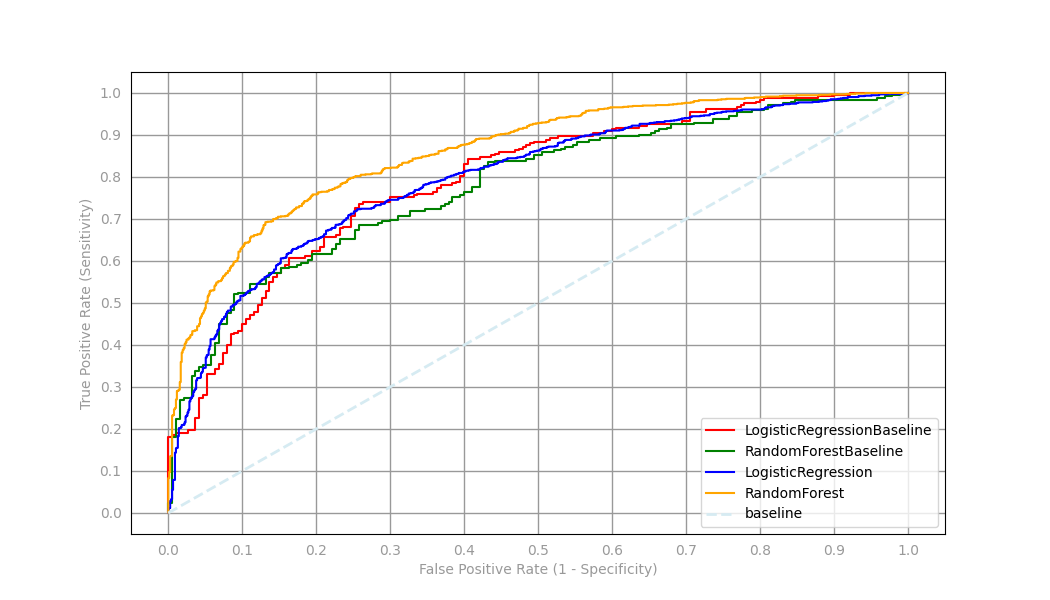

In [145]:
fig, ax = prepare_plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(fpr_lr_baseline, tpr_lr_baseline, color='r', label="LogisticRegressionBaseline")
plt.plot(fpr_rf_baseline, tpr_rf_baseline, color='g', label="RandomForestBaseline")
plt.plot(fpr_lr, tpr_lr, color='b', label="LogisticRegression")
plt.plot(fpr_rf, tpr_rf, color='orange', label="RandomForest")
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2',
         linewidth=2., label="baseline")  # Baseline model
plt.legend()

%matplot plt

### 2.2.6 Do Your Best


In all previous sections in this assignment and other assignments so far, we have almost specified everything you should do. You might be (and should be!) bored by now. This section gives you a chance to do whatever you want to improve the prediction AUC.

You can do better data preprocessing, feature engineering, fit fancier models, perform hyperparameter tuning, etc.

✰2.2.6 after you are satisfied with your model, report in your writeup

- the hyperparameters,
- train and test AUC of your optimized model, and
- the approach you took on top of the specified instructions to obtain this better result.


In [168]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define Random Forest Model
rf = RandomForestClassifier(labelCol="popularity", featuresCol="final_scaled_features")

# Create Parameter Grid for Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 75]) \
    .addGrid(rf.maxDepth, [5, 7]) \
    .addGrid(rf.minInstancesPerNode, [5, 10]) \
    .addGrid(rf.featureSubsetStrategy, ["sqrt", "log2"]) \
    .build()

# Define Cross Validator
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=BinaryClassificationEvaluator(labelCol="popularity", metricName="areaUnderROC"),
                    numFolds=5)  # 5-fold Cross Validation

# Train the Optimized Model
cv_model = cv.fit(train_data)

# Make Predictions
rf_train_predictions = cv_model.transform(train_data)
rf_test_predictions = cv_model.transform(test_data)

# Evaluate the Best Model
auc_evaluator = BinaryClassificationEvaluator(labelCol="popularity", rawPredictionCol="prediction", metricName="areaUnderROC")

rf_train_auc = auc_evaluator.evaluate(rf_train_predictions)
rf_test_auc = auc_evaluator.evaluate(rf_test_predictions)

# Print Results
print(f"Optimized Random Forest Train AUC: {rf_train_auc:.4f}")
print(f"Optimized Random Forest Test AUC: {rf_test_auc:.4f}")
print("Best Parameters:", cv_model.bestModel.extractParamMap())


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimized Random Forest Train AUC: 0.8255
Optimized Random Forest Test AUC: 0.7125
Best Parameters: {Param(parent='RandomForestClassifier_6eb8b920e01c', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_6eb8b920e01c', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_6eb8b920e01c', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_6eb8b920e01c', name='f

### 2.2.7 Don't forget to answer the reflection question on the writeup! ✰2.2.7
